Notebook for making plots found in feasible_manuscript.tex
---

In [7]:
from __future__ import division
import agg_fxns as agg
import pandas as pd
import macroeco.compare as comp
import scipy.stats as stats
import pypartitions as pyp
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

plt.style.use('ggplot')

# Some plotting properties
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.edgecolor'] = 'black'#'#555555'
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['text.usetex'] = False
colors = plt.rcParams['axes.color_cycle']

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Plots for top-down and bottom-up predictions with no heterogeneity for all species

In [8]:
# Load in the no-heterogeneity results
td_bu_vectors = pd.read_pickle("../results/pickled_results/no_heterogeneity_all_years_vectors.pkl")
td_bu_stats = pd.read_pickle("../results/pickled_results/no_heterogeneity_all_years_stats.pkl")

In [9]:
reload(agg)
hosts = ["BUBO", "PSRE", "RACA", "TATO", "TAGR"]
parasites = ['RION', 'ECSP', 'ALAR', "GLOB", "MANO"]
models = ['feasible', 'trun_geometric', 'binomial']

overall_res = {}
for model in models:
    
    overall_res[model] = []
    
    for i, host in enumerate(hosts):
        for j, parasite in enumerate(parasites):
        
            foldernm = "../results/plots/no_heterogeneity_plots/"
            savenm = foldernm + "no_heterogeneity_{0}_{1}_{2}.pdf".format(model, host, parasite)
            savenm2 = foldernm + "no_heterogeneity_{0}_{1}_{2}_no_hist.pdf".format(model, host, parasite)
            
            try:
                rsqs, adp = zip(*agg.extract_obs_pred_stats(td_bu_stats, model, 
                                    host, parasite, ["r_sq_one_to_one", "AD_p_val"]))
                adp = np.array(adp)
                prop_reject = np.sum(adp < 0.1) / np.float(len(adp))
                obs, pred = agg.extract_obs_pred_vectors(td_bu_vectors, model, host, parasite)
                overall_rsq = comp.r_squared(np.concatenate(obs) + 1, np.concatenate(pred) + 1, one_to_one=True,
                                                     log_trans=True)
                overall_res[model].append((host + ":" + parasite, 1 - prop_reject, overall_rsq, 
                                                   np.median(rsqs), 
                                                   stats.scoreatpercentile(rsqs, 25),
                                                   stats.scoreatpercentile(rsqs, 75),
                                                   np.var(rsqs, ddof=1),
                                                   len(rsqs)))
                
                # Uncomment to make host by parasite plots
                agg.plot_vectors(np.concatenate(obs), np.concatenate(pred), rsqs=None, 
                            savename=savenm2, proportion=None, xlim=None, ylim=None)
                plt.close()
                agg.plot_vectors(np.concatenate(obs), np.concatenate(pred), rsqs=rsqs, 
                            savename=savenm, proportion=(len(rsqs), 1 - prop_reject), xlim=None, ylim=None)
                plt.close()
                
            except ValueError:
                overall_res[model].append((host + ":" + parasite, np.nan, np.nan))

## Plotting the overall R-squared values and proportion fit by host parasite combination


In [10]:
# Convert results to dataframes for plotting
binom_data = pd.DataFrame(overall_res['binomial'], columns=["host_para", "binom_prop", "binom_rsq", "binom_med_rsq", "binom_lower_rsq", "binom_upper_rsq", "binom_var_rsq", "binom_samp_size"]).set_index("host_para")
feas_data = pd.DataFrame(overall_res['feasible'], columns=["host_para", "feas_prop", "feas_rsq", "feas_med_rsq", "feas_lower_rsq", "feas_upper_rsq", "feas_var_rsq", "feas_samp_size"]).set_index("host_para")
maxent_data = pd.DataFrame(overall_res['trun_geometric'], columns=["host_para", "maxent_prop", "maxent_rsq", "maxent_med_rsq", "maxent_lower_rsq", "maxent_upper_rsq", "maxent_var_rsq", "maxent_samp_size"]).set_index("host_para")


In [11]:
# Make parasite and host specific rows
full_data = binom_data.join([feas_data, maxent_data])
full_data['host'] = [ind.split(":")[0] for ind in full_data.index]
full_data['para'] = [ind.split(":")[1] for ind in full_data.index]

# Remove TAGR
full_data = full_data[:-5]

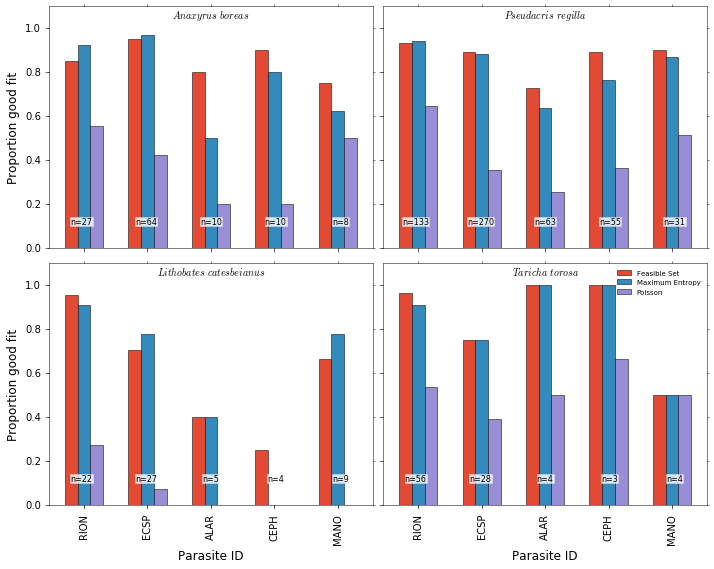

In [12]:
# Make the figure for proportion fitting models
suffix = "prop" 

fig, axes = plt.subplots(2, 2, sharey=True, sharex=True)
axes = axes.ravel()
grouped_data = full_data.groupby("host")
names = {"BUBO": r"$Anaxyrus$ $boreas$", "PSRE": r"$Pseudacris$ $regilla$", 
                 "TATO": r"$Taricha$ $torosa$", 
                "RACA": r"$Lithobates$ $catesbeianus$"}
para_names = ["RION", "ECSP", "ALAR", "CEPH", "MANO"]

for i, group in enumerate(grouped_data):
    
    group[1].plot(x='para', y=['feas_' + suffix, 'maxent_' + suffix, 'binom_' + suffix], ax=axes[i], kind="bar", 
                                           width=0.6, figsize=(10, 8), edgecolor=['black'], color=colors)
    
    axes[i].tick_params(right=None, top=None)
    
    if axes[i].is_first_col():
        axes[i].set_ylabel("Proportion good fit")
    
    if axes[i].is_last_row():
        axes[i].set_xlabel("Parasite ID")
        axes[i].set_xticklabels(para_names)
    else:
        axes[i].set_xlabel('')
        
        
    if i == 3:
        axes[i].legend([ "Feasible Set","Maximum Entropy", "Poisson"], prop={'size' : 7}, frameon=False)
    else:
        leg = axes[i].legend()
        leg.remove()
    axes[i].set_ylim(0, 1.1)
    axes[i].set_yticklabels(np.linspace(0, 1.0, num=6))
    axes[i].text(0.5, .95, names[group[0]], ha="center", transform=axes[i].transAxes)
    
    # Put sample sizes above plots
    for j in range(len(group[1])):
        axes[i].text(((j + 1) / 5) - 0.1, 0.1, "n={0}".format(int(group[1].binom_samp_size.iloc[j])), size=8,
                                         ha="center", transform=axes[i].transAxes, 
                                         bbox=dict(facecolor='white', pad=0.1, alpha=0.8))

plt.tight_layout()
plt.savefig("../results/good_fit_summary_fig.pdf")

/Users/mqwilber/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:929: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


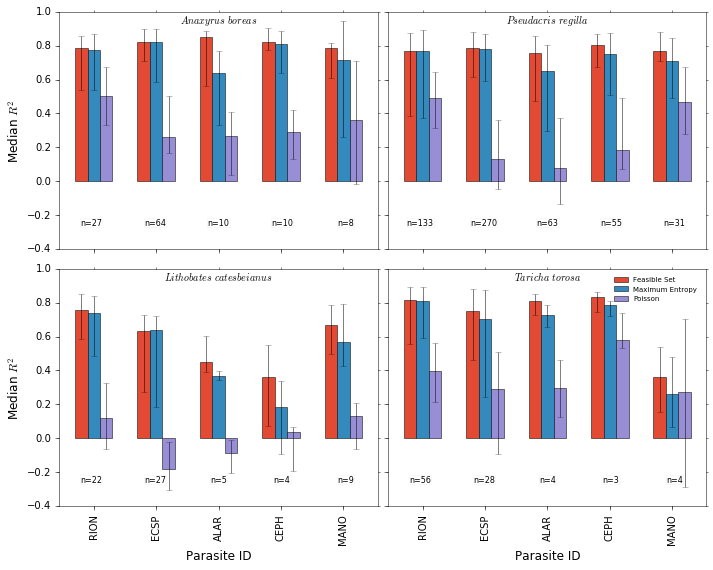

In [13]:
# Make the figure for median R^2s for the different models
suffix = "med_rsq" 


fig, axes = plt.subplots(2, 2, sharey=True, sharex=True)
axes = axes.ravel()
grouped_data = full_data.groupby("host")
names = {"BUBO": r"$Anaxyrus$ $boreas$", "PSRE": r"$Pseudacris$ $regilla$", 
                 "TATO": r"$Taricha$ $torosa$", 
                "RACA": r"$Lithobates$ $catesbeianus$"}
para_names = ["RION", "ECSP", "ALAR", "CEPH", "MANO"]

x = np.arange(5)
pm = 0.2

for i, group in enumerate(grouped_data):
    
    # Store the xs and ys for plotting
    full_xs = []
    full_ys_med = []
    full_ys_upper = []
    full_ys_lower = []
    
    for j, para in enumerate(group[1].para):

        xs = [x[j] - pm, x[j], x[j] + pm]
        ys_med = [group[1].feas_med_rsq[j], group[1].maxent_med_rsq[j], group[1].binom_med_rsq[j]]
        ys_upper = [group[1].feas_upper_rsq[j], group[1].maxent_upper_rsq[j], group[1].binom_upper_rsq[j]]
        ys_lower = [group[1].feas_lower_rsq[j], group[1].maxent_lower_rsq[j], group[1].binom_lower_rsq[j]]
        
        full_xs.append(xs)
        full_ys_med.append(ys_med)
        full_ys_upper.append(ys_upper)
        full_ys_lower.append(ys_lower)
    
    # Start the plotting
    lower = np.concatenate(full_ys_lower)
    upper = np.concatenate(full_ys_upper)
    med = np.concatenate(full_ys_med)
    x_vals = np.concatenate(full_xs)
    
    group[1].plot(x='para', y=['feas_' + suffix, 'maxent_' + suffix, 'binom_' + suffix], ax=axes[i], kind="bar", 
                                           width=0.6, figsize=(10, 8), edgecolor=['black'], colors=colors)
    
    axes[i].errorbar(x_vals, med, yerr=[med - lower, upper - med], marker='', linestyle='', color="black", alpha=0.5)
    axes[i].tick_params(right=None, top=None)
    
    if axes[i].is_first_col():
        axes[i].set_ylabel("Median $R^2$")
    
    if axes[i].is_last_row():
        axes[i].set_xlabel("Parasite ID")
        axes[i].set_xticklabels(para_names)
    else:
        axes[i].set_xlabel("")
        
        
    if i == 3:
        axes[i].legend(["", "Feasible Set","Maximum Entropy", "Poisson"], prop={'size' : 7}, frameon=False, 
                      loc=(0.7, 0.85))
    else:
        leg = axes[i].legend()
        leg.remove()
    #axes[i].set_ylim(0, 1.1)
    #axes[i].set_yticklabels(np.linspace(0, 1.0, num=6))
    axes[i].text(0.5, .95, names[group[0]], ha="center", transform=axes[i].transAxes)
        # Put sample sizes above plots
    for j in range(len(group[1])):
        axes[i].text(((j + 1) / 5) - 0.1, 0.1, "n={0}".format(int(group[1].binom_samp_size.iloc[j])), size=8,
                                         ha="center", transform=axes[i].transAxes, 
                                         bbox=dict(facecolor='white', pad=0.1, alpha=0.8))

plt.tight_layout()
plt.savefig("../results/median_r_sq_summary_fig.pdf")

/Users/mqwilber/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


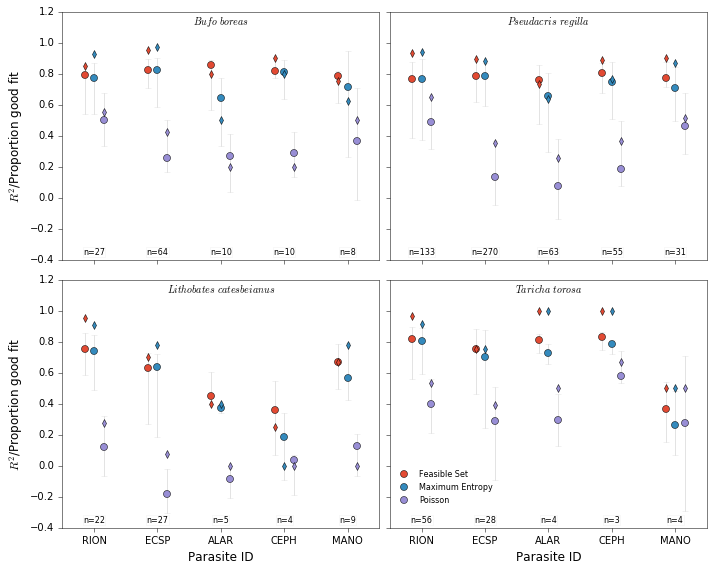

In [14]:
# Another plot with both bits of information onf the same plot.  A bit crowded
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True, sharex=True)
axes = axes.ravel()
grouped_data = full_data.groupby("host")
names = {"BUBO": r"$Bufo$ $boreas$", "PSRE": r"$Pseudacris$ $regilla$", 
                 "TATO": r"$Taricha$ $torosa$", 
                "RACA": r"$Lithobates$ $catesbeianus$"}

NUM_PARA = 5 # 5 parasites to consider
xlabels = ["RION", "ECSP", "ALAR", "CEPH", "MANO"]
x = np.arange(0, 2*NUM_PARA, step=2)
pm = 0.3 # increment

for i, group in enumerate(grouped_data):
    
    # Store the xs and ys for plotting
    full_xs = []
    full_ys_med = []
    full_ys_upper = []
    full_ys_lower = []
    full_props = []
    
    for j, para in enumerate(group[1].para):

        xs = [x[j] - pm, x[j], x[j] + pm]
        ys_med = [group[1].feas_med_rsq[j], group[1].maxent_med_rsq[j], group[1].binom_med_rsq[j]]
        ys_upper = [group[1].feas_upper_rsq[j], group[1].maxent_upper_rsq[j], group[1].binom_upper_rsq[j]]
        ys_lower = [group[1].feas_lower_rsq[j], group[1].maxent_lower_rsq[j], group[1].binom_lower_rsq[j]]
        ps = [group[1].feas_prop[j], group[1].maxent_prop[j], group[1].binom_prop[j]]
        
        full_xs.append(xs)
        full_ys_med.append(ys_med)
        full_ys_upper.append(ys_upper)
        full_ys_lower.append(ys_lower)
        full_props.append(ps)
    
    # Start the plotting
    lower = np.concatenate(full_ys_lower)
    upper = np.concatenate(full_ys_upper)
    med = np.concatenate(full_ys_med)
    props = np.concatenate(full_props)
    
    x_vals = np.concatenate(full_xs)
    
    p1 = axes[i].plot(np.r_[full_xs], np.r_[full_ys_med], marker='o', linestyle='', ms=7)
    axes[i].errorbar(x_vals, med, yerr=[med - lower, upper - med], marker='', linestyle='', alpha=0.2)
    
    # Reset color cycle
    axes[i].set_color_cycle(colors)
    
    #tax2 = axes[i].twinx()
    p2 = axes[i].plot(np.r_[full_xs], np.r_[full_props], marker='d', linestyle='', ms=5, alpha=1)
    #tax2.set_ylim(-0.4, 1.2)
    
    axes[i].tick_params(top=None, right=None)
    #axes[i].hlines(0, *axes[i].get_xlim(), linestyle="dashed", color="black", alpha=0.5)
    
    # Host Name
    axes[i].text(0.5, .95, names[group[0]], ha="center", transform=axes[i].transAxes)
    
    # Sample size
    for k in np.arange(len(x)):
        axes[i].text(x[k], -0.35, "n={0}".format(int(group[1].binom_samp_size.iloc[k])), size=8,
                                         ha="center", va="center",
                                         bbox=dict(facecolor='white', pad=0.1, alpha=0.8), zorder=5)
    
    if axes[i].is_first_col():
        axes[i].set_ylabel("$R^2$/Proportion good fit")
    
    if axes[i].is_last_row():
        axes[i].set_xlabel("Parasite ID")
    
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(xlabels)
    axes[i].set_xlim(-1, np.max(x) + 1)
    
    if i == 3:
        fs_circ = plt.Line2D((0, 1), (0, 0), marker='o', ms=7, linestyle='', color=colors[0])
        fs_diamond = plt.Line2D((0, 1), (0, 0), marker='d', ms=5, linestyle='', color=colors[0])
        me_circ = plt.Line2D((0, 1), (0, 0), marker='o', ms=7, linestyle='', color=colors[1])
        me_diamond = plt.Line2D((0, 1), (0, 0), marker='d', ms=5, linestyle='', color=colors[1])
        bn_circ = plt.Line2D((0, 1), (0, 0), marker='o', ms=7, linestyle='', color=colors[2])
        bn_diamond = plt.Line2D((0, 1), (0, 0), marker='d', ms=5, linestyle='', color=colors[2])
        
        
        axes[i].legend(["Feasible Set", "Maximum Entropy", "Poisson"], loc=(0.01, 0.08), 
                       prop={'size':8}, frameon=False, numpoints=1)
        

plt.tight_layout()
#plt.savefig("../results/median_r_sq_summary_fig_with_error_bars.pdf")

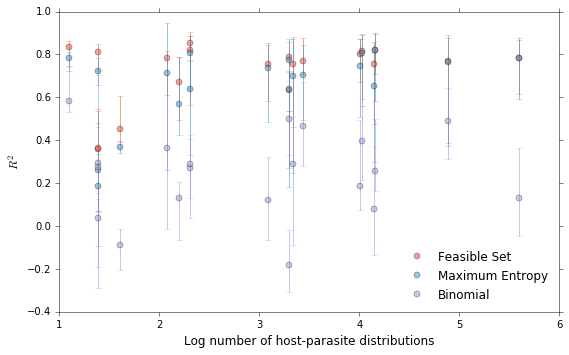

In [15]:
# Is there any trend in R^2 with sample size? 
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Plot the Distribution of r^2s against samples size

lower = np.array(full_data.feas_med_rsq) - np.array(full_data.feas_lower_rsq)
upper = np.array(full_data.feas_upper_rsq) - np.array(full_data.feas_med_rsq)
ax.errorbar(np.log(full_data.feas_samp_size), full_data.feas_med_rsq, 
            yerr=[lower, upper], linestyle="", marker='o', alpha=0.5, label="Feasible Set")

lower = np.array(full_data.maxent_med_rsq) - np.array(full_data.maxent_lower_rsq)
upper = np.array(full_data.maxent_upper_rsq) - np.array(full_data.maxent_med_rsq)
ax.errorbar(np.log(full_data.maxent_samp_size), full_data.maxent_med_rsq, 
            yerr=[lower, upper], linestyle="", marker='o', alpha=0.5, label="Maximum Entropy")

lower = np.array(full_data.binom_med_rsq) - np.array(full_data.binom_lower_rsq)
upper = np.array(full_data.binom_upper_rsq) - np.array(full_data.binom_med_rsq)
ax.errorbar(np.log(full_data.binom_samp_size), full_data.binom_med_rsq, 
            yerr=[lower, upper], linestyle="", marker='o', alpha=0.5, label="Binomial")

ax.set_xlabel("Log number of host-parasite distributions")
ax.set_ylabel("$R^2$")
ax.legend(["Feasible Set", "Maximum Entropy", "Binomial"], numpoints=1, loc="lower right", frameon=False)

plt.tight_layout()
plt.savefig("../results/rsq_trend.pdf")

## Plot discrete heterogeneity results for overaggregated sites

Just going to plot for group 1 through 3. These heterogeneity results have used a regression analysis with svl and 
coinfection as predictors.  You can try using total trematode load and it doesn't change the results

In [16]:
# Load in discrete results
discrete_stats = pd.read_pickle("../results/pickled_results/discrete_known_heterogeneity_all_years_stats_all_para.pkl")
discrete_vects = pd.read_pickle("../results/pickled_results/discrete_known_heterogeneity_all_years_vectors_all_para.pkl")

# Load in ids for all aggregated sites
over_agg_sites_all = pd.read_pickle("../results/pickled_results/overaggregated_sites.pkl")[0]

# Load in random results
random_stats = pd.read_pickle("../results/pickled_results/randomized_known_heterogeneity_stats.pkl")
random_vects = pd.read_pickle("../results/pickled_results/randomized_known_heterogeneity_vects.pkl")

# Reload in the no-heterogeneity results
td_bu_vects = pd.read_pickle("../results/pickled_results/no_heterogeneity_all_years_vectors.pkl")
td_bu_stats = pd.read_pickle("../results/pickled_results/no_heterogeneity_all_years_stats.pkl")

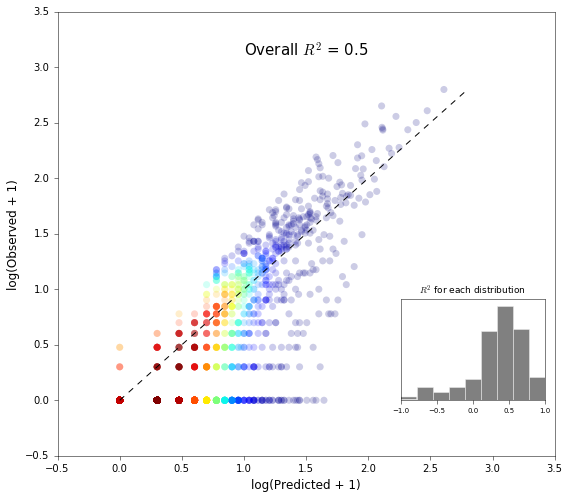

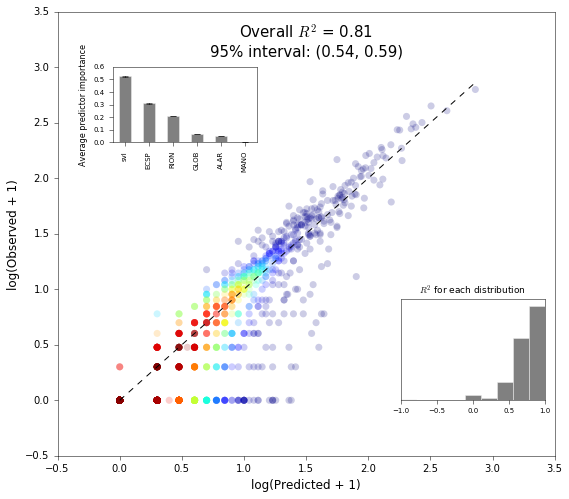

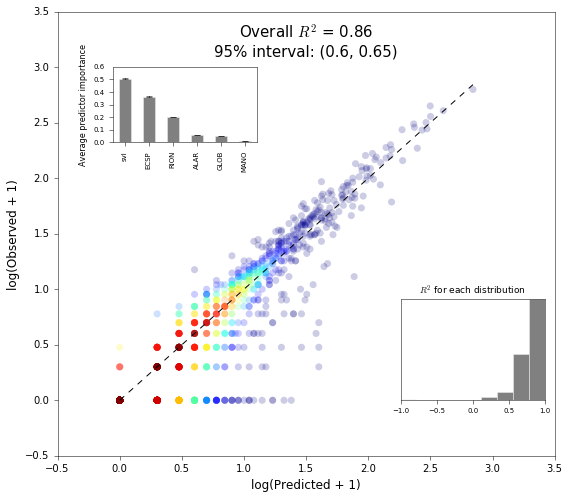

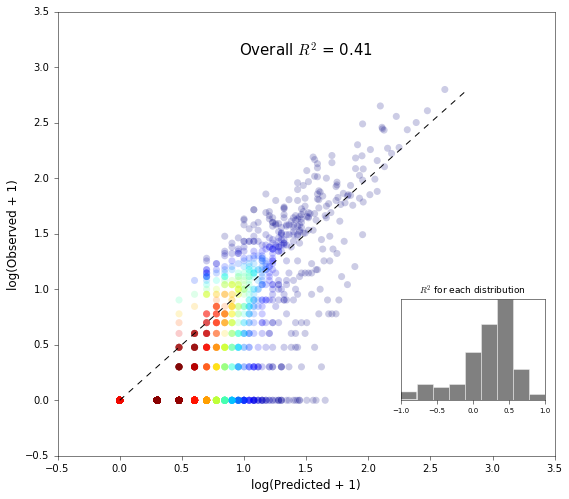

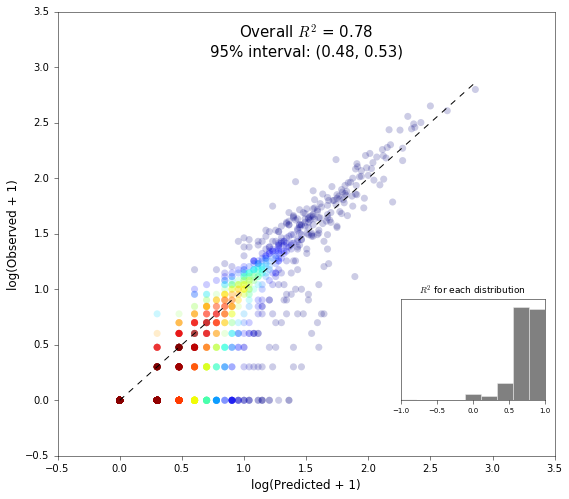

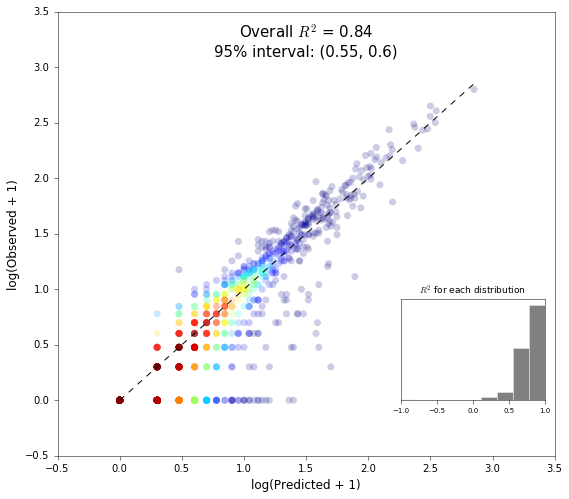

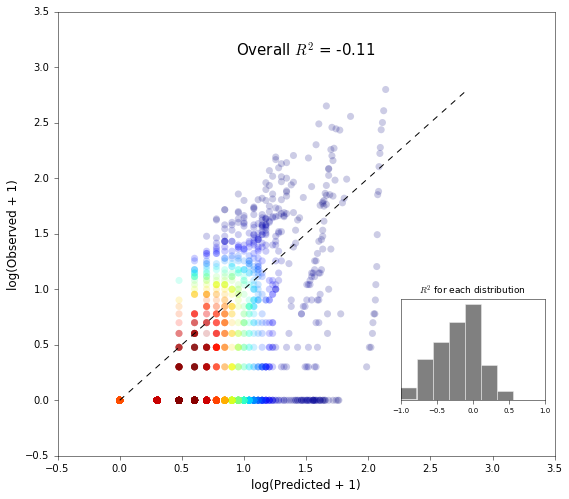

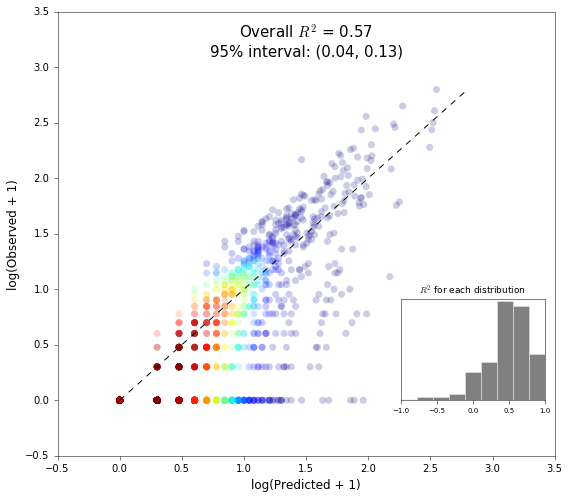

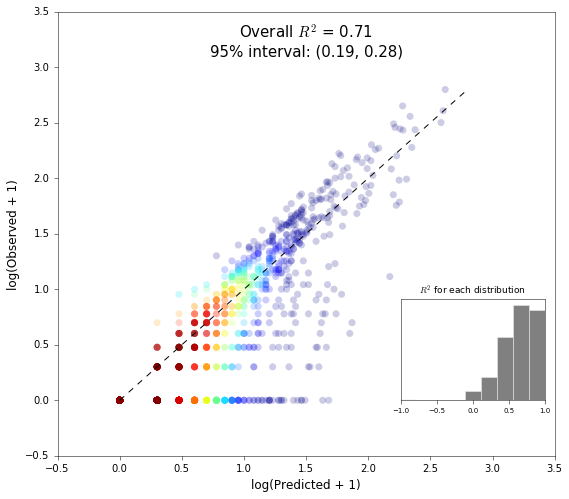

In [17]:
reload(agg)
# Extract the observed which will always be the same
obs = agg.extract_vectors_given_tuple(td_bu_vects, over_agg_sites_all, "observed")
#fig, axes = plt.subplots(3, 3, figsize=(10, 10))

models = ['feasible', 'trun_geometric', 'binomial']
groups = np.arange(1, 4)

for row in np.arange(3):
    model = models[row]
    for col in np.arange(3):
        
        vect_dict = discrete_vects
        stats_dict = discrete_stats
        model_nm = model + "_{0}".format(col + 1)
        
        pred = agg.extract_vectors_given_tuple(vect_dict, over_agg_sites_all, model_nm)
        rsqs = rsqs1 = [x.ix['r_sq_one_to_one'] for x in 
                        agg.extract_vectors_given_tuple(stats_dict, over_agg_sites_all, model_nm)]
        
        # Compute the randomization interval for the overall R^2
        if col > 0: # If group num > 1, extract rsqs
            rand_mat = np.concatenate(agg.extract_overall_rsq_from_random(random_vects, 
                                over_agg_sites_all, col + 1, model), axis=1)
            overall_rqs = [comp.r_squared(np.concatenate(obs) + 1, pr + 1, 
                                              log_trans=True, one_to_one=True) for pr in rand_mat]
            ci95 = tuple(stats.scoreatpercentile(overall_rqs, (2.5, 97.5)))
            
            if model == "feasible":
                importance = agg.extract_var_importance(discrete_stats, over_agg_sites_all, model_nm)
            else:
                importance = None
        else:
            ci95 = None
            importance = None
            
        agg.plot_vectors(np.concatenate(obs), np.concatenate(pred), rsqs=rsqs, ci95=ci95, importance=importance,
                        savename="../results/overaggregated_plots_{0}_{1}.pdf".format(model, col + 1))

## Plots for top-down and bottom-up predictions with continuous heterogeneity for all species

In [19]:
# Load in the no-heterogeneity results
td_bu_cont_vectors = pd.read_pickle("../results/pickled_results/continuous_heterogeneity_all_years_vectors.pkl")
td_bu_cont_stats = pd.read_pickle("../results/pickled_results/continuous_heterogeneity_all_years_stats.pkl")

/Users/mqwilber/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


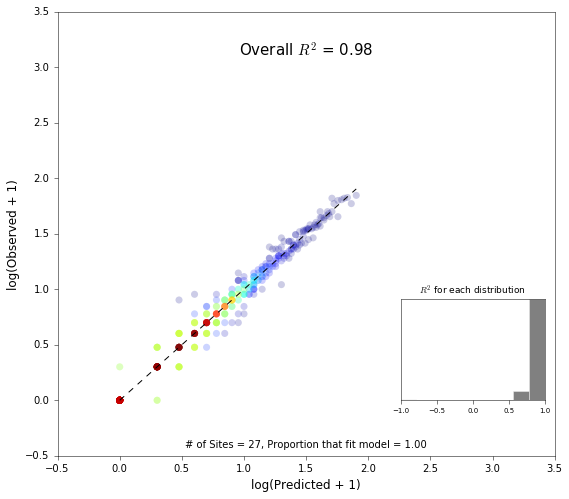

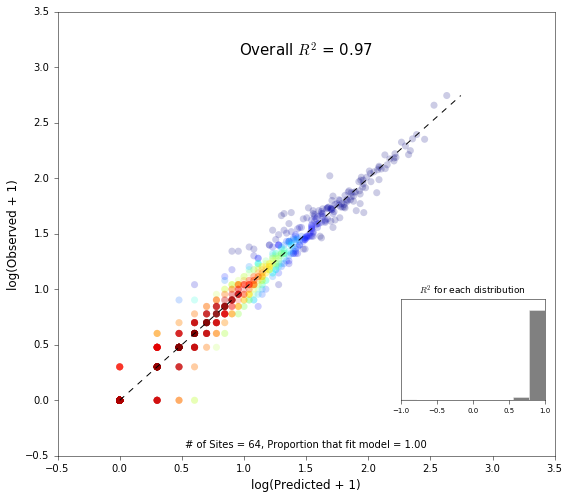

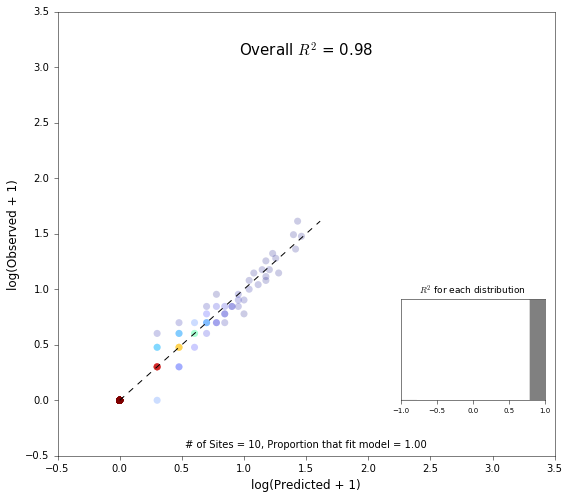

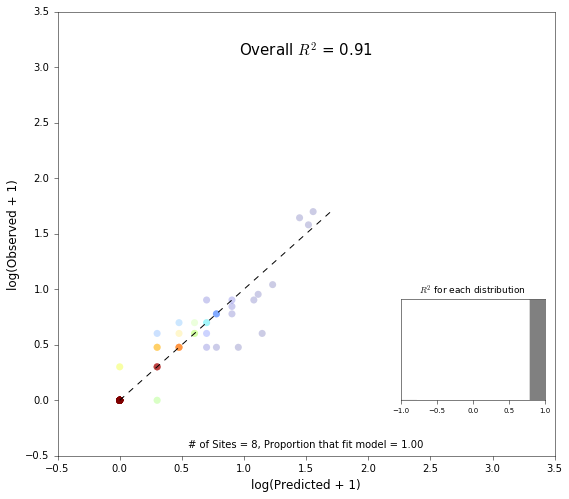

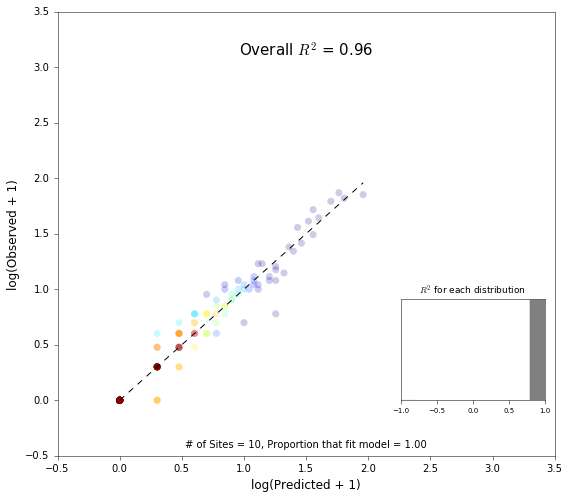

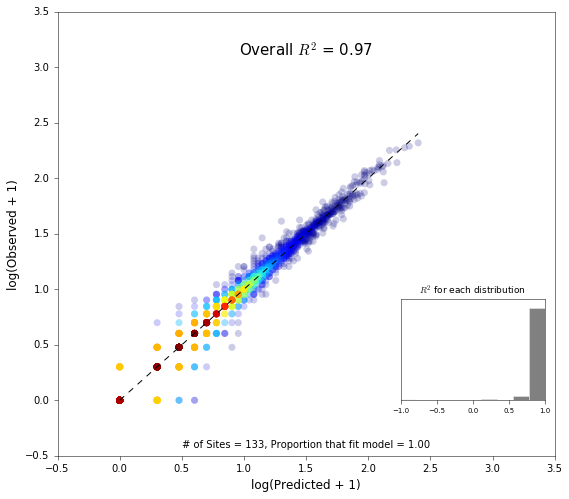

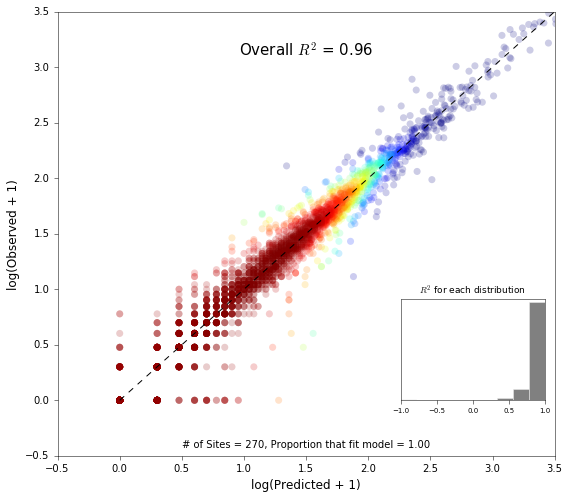

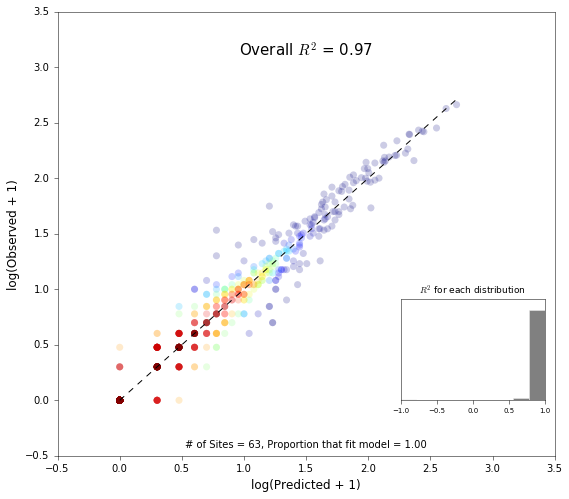

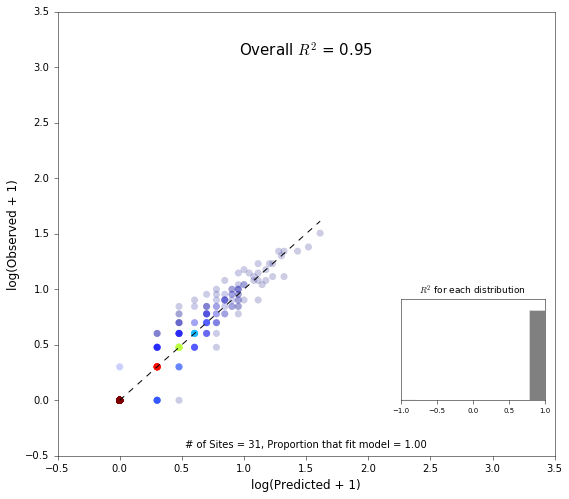

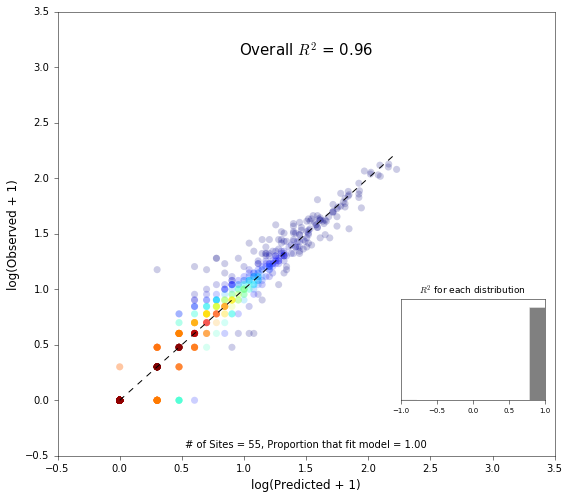

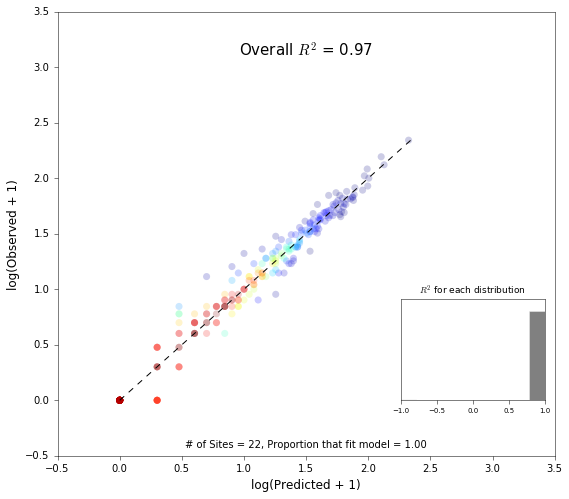

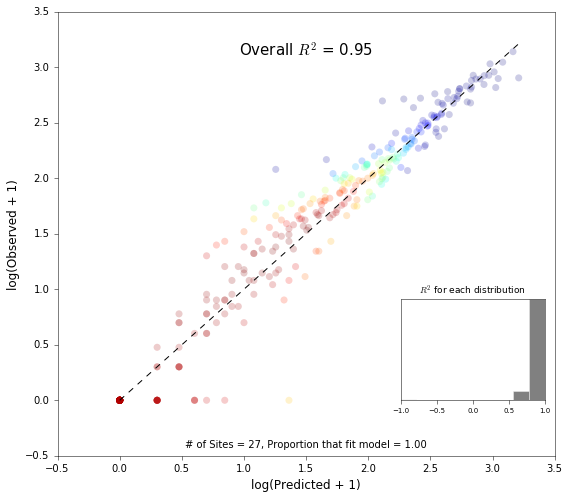

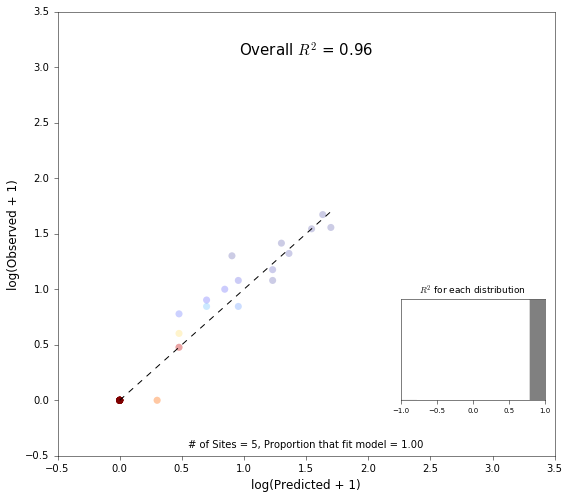

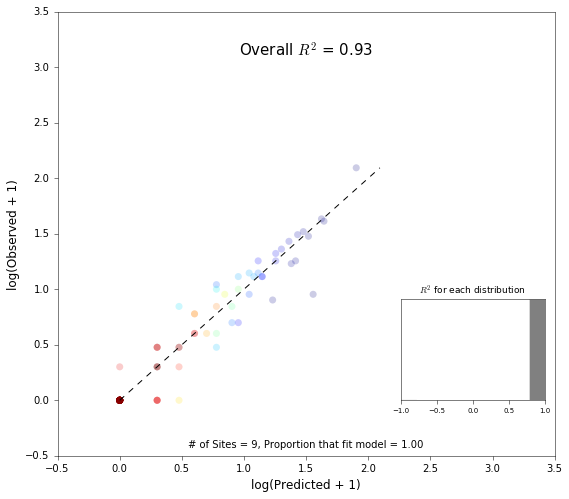

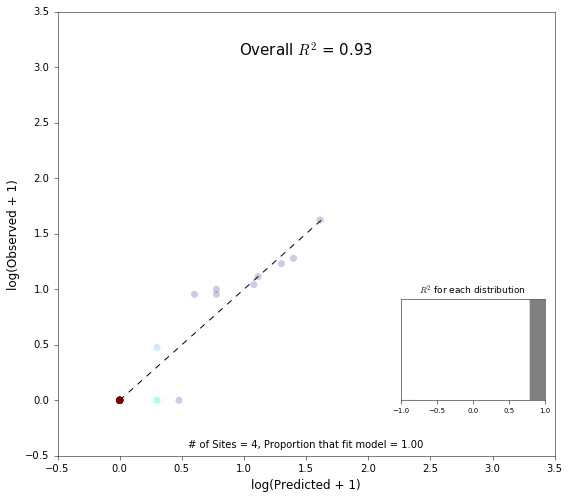

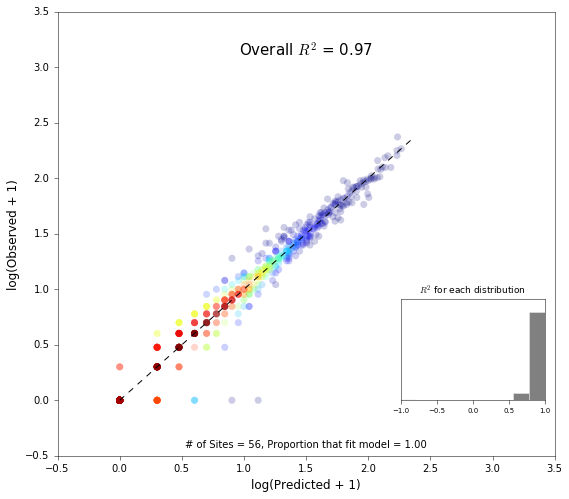

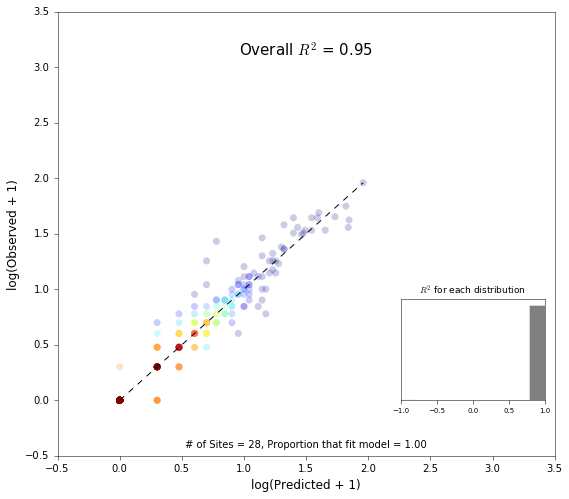

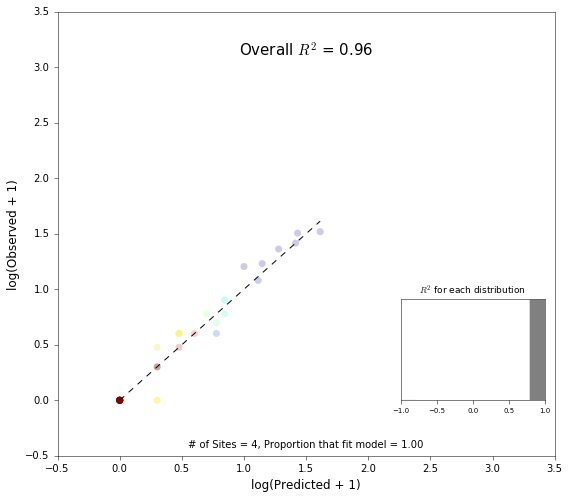

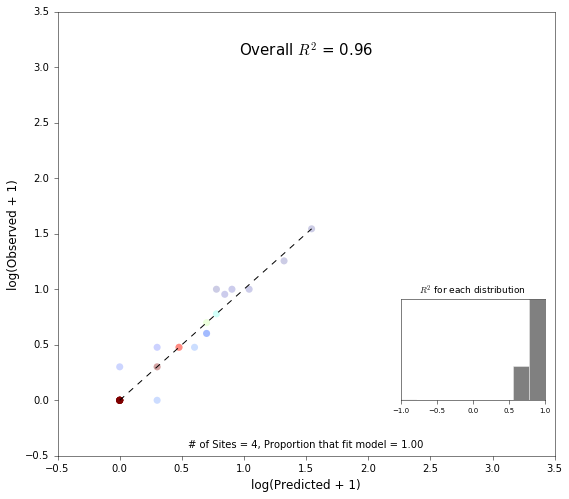

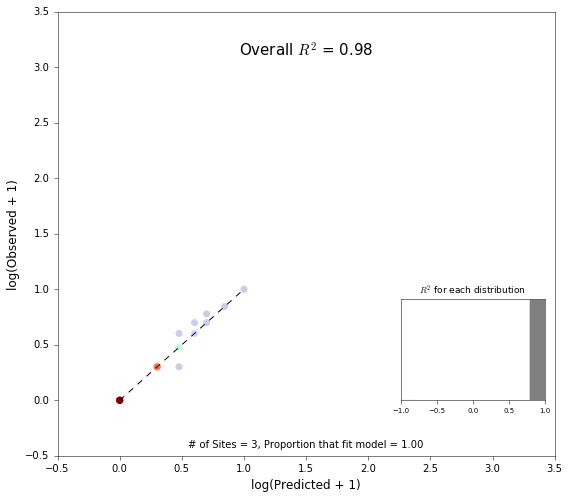

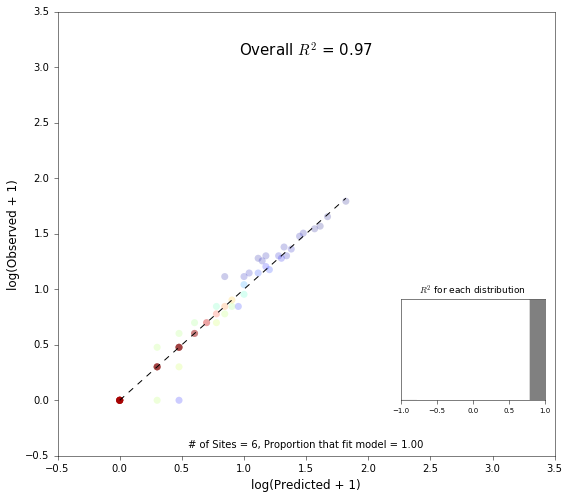

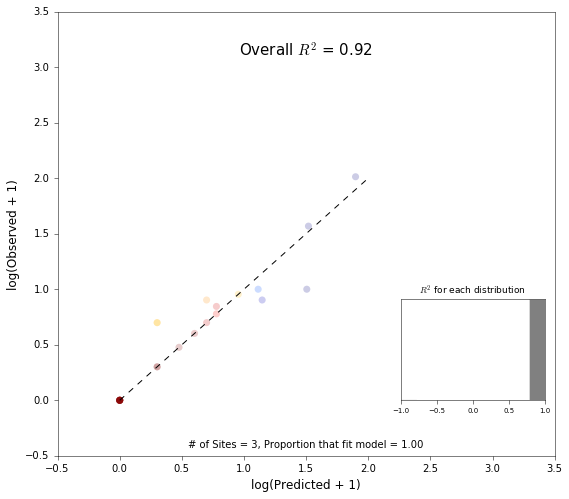

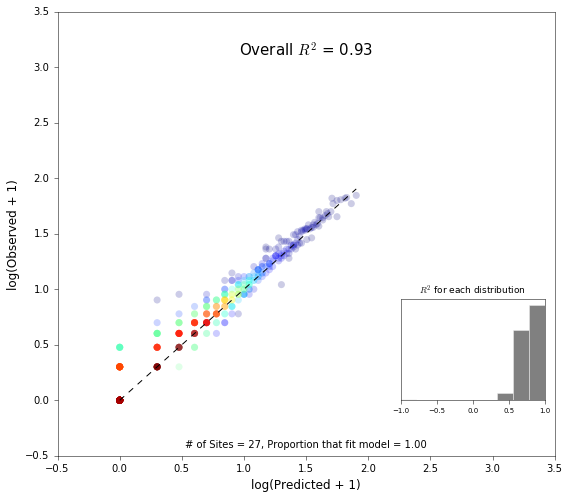

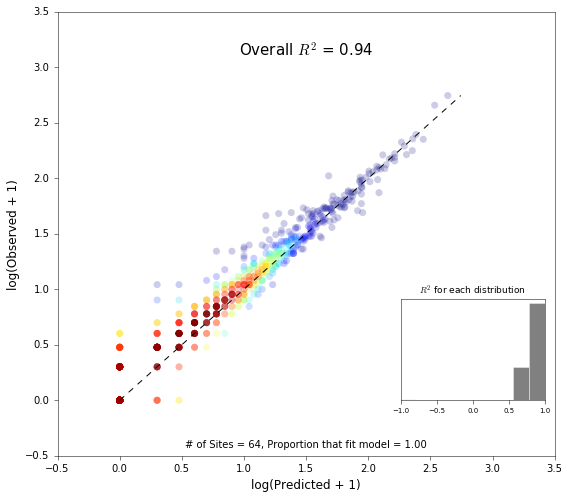

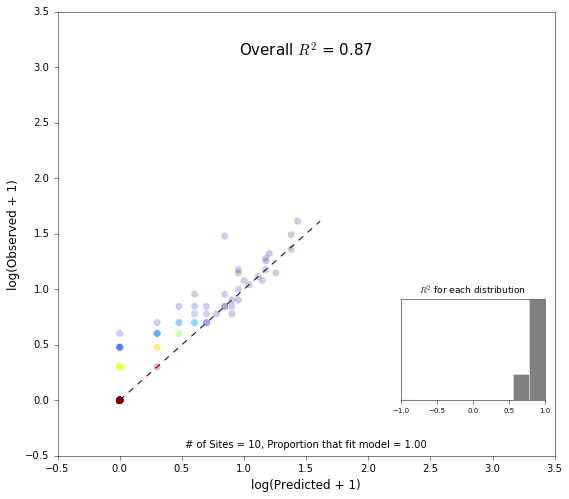

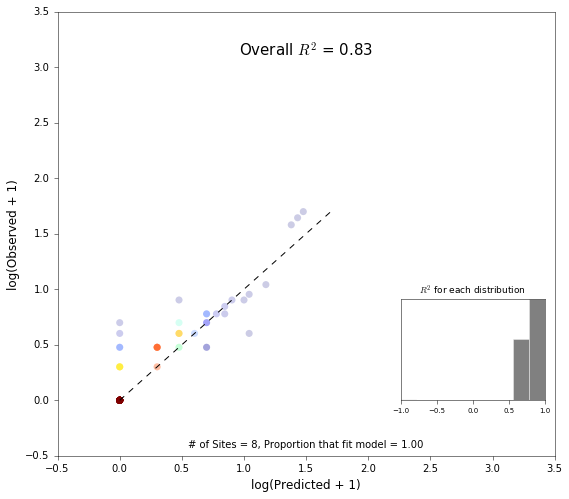

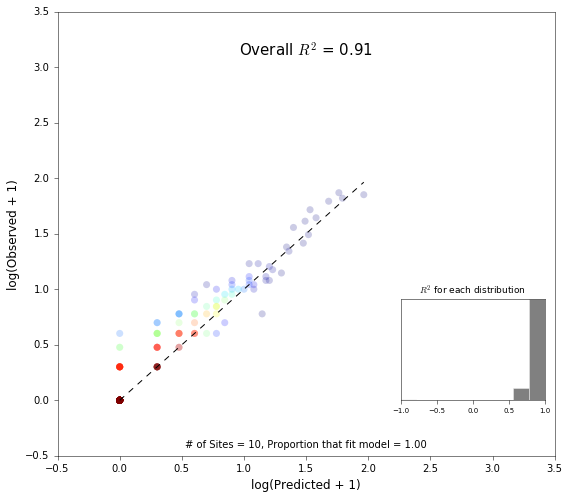

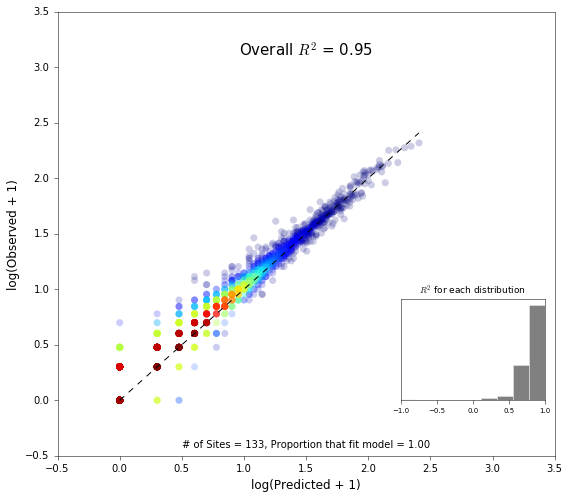

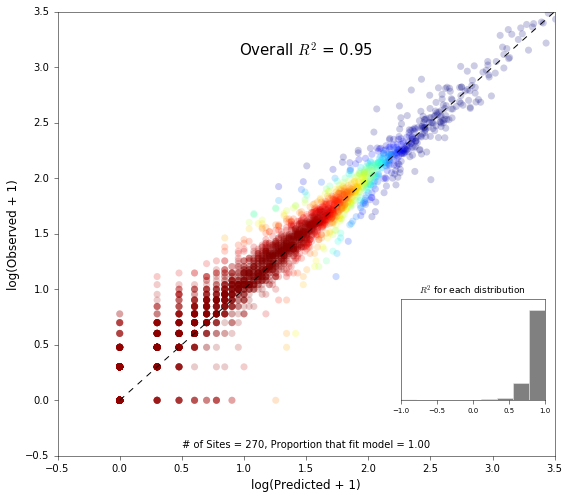

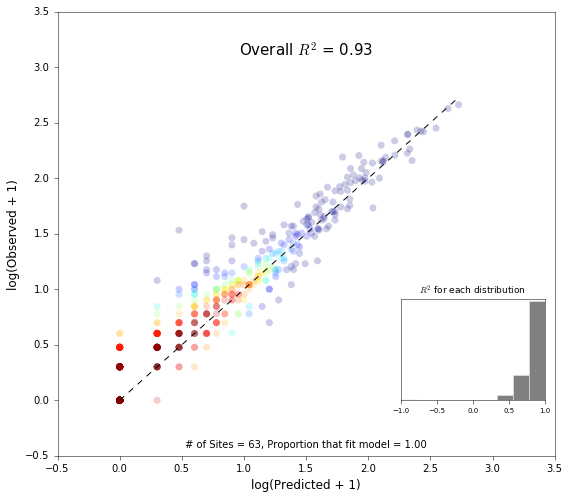

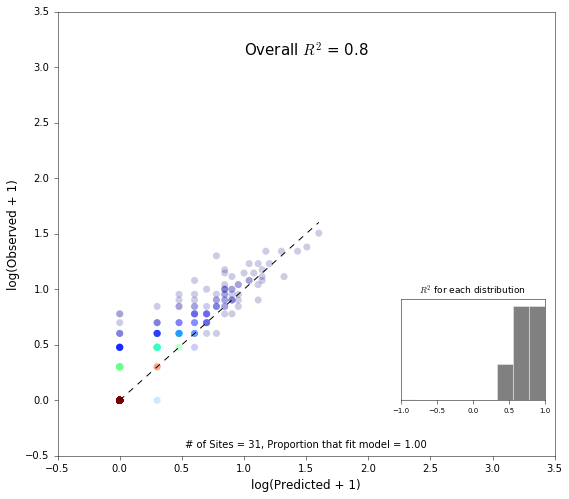

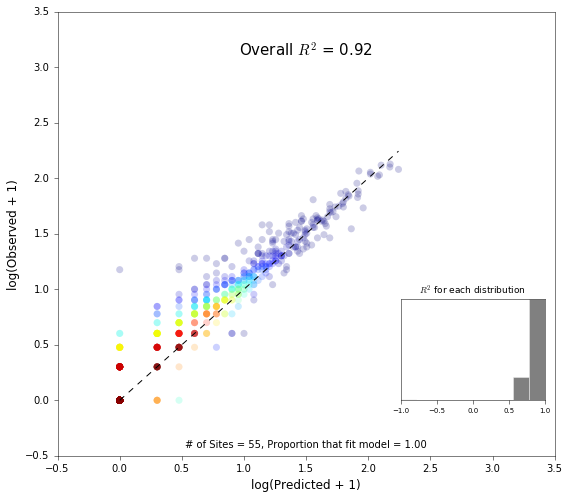

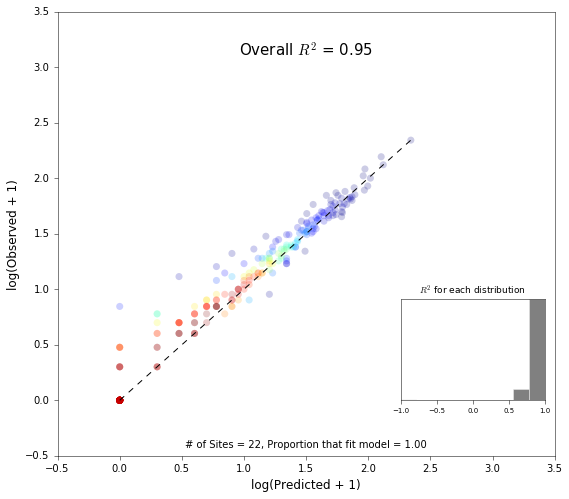

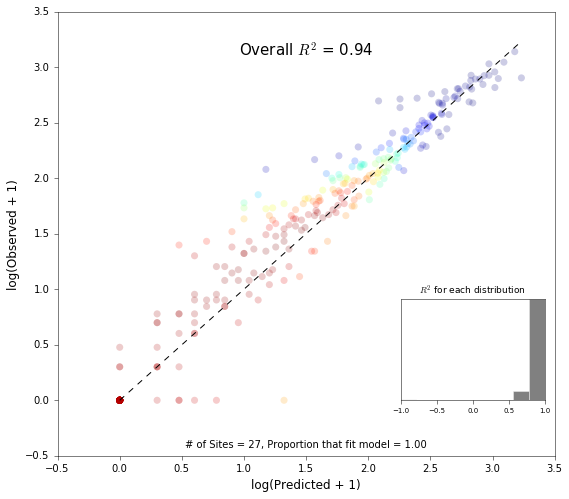

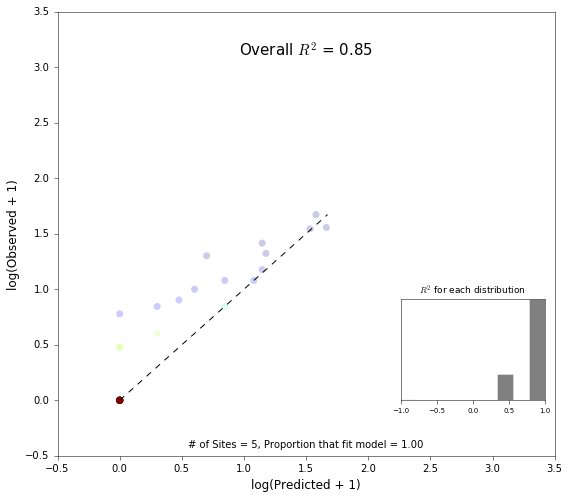

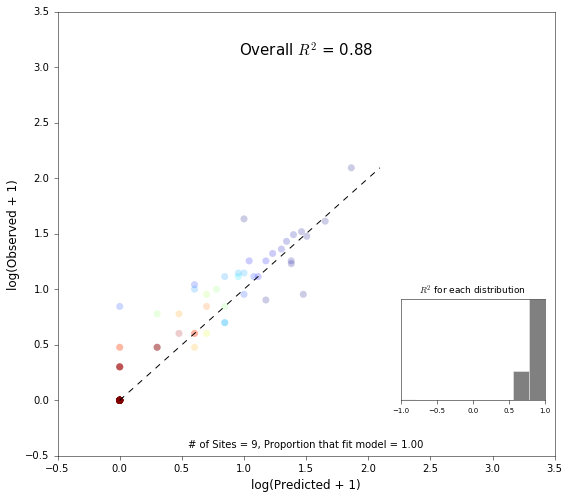

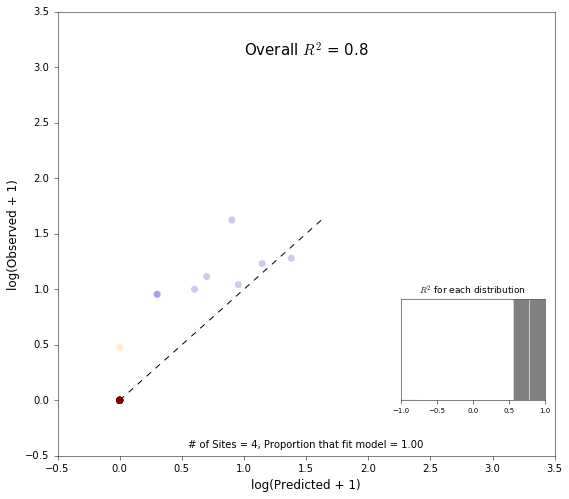

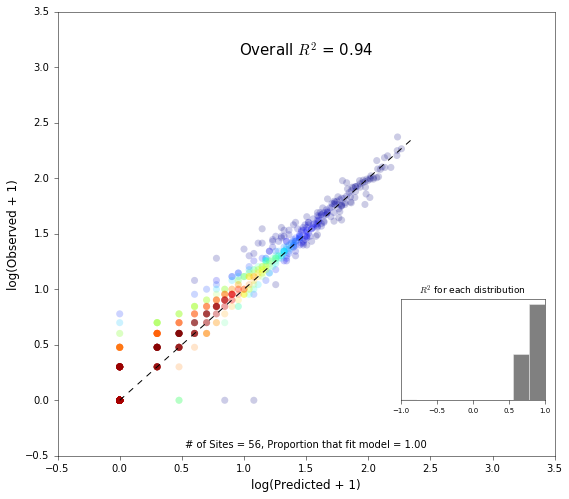

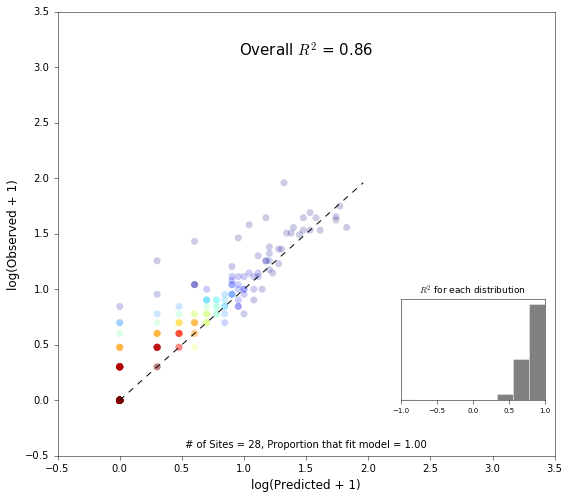

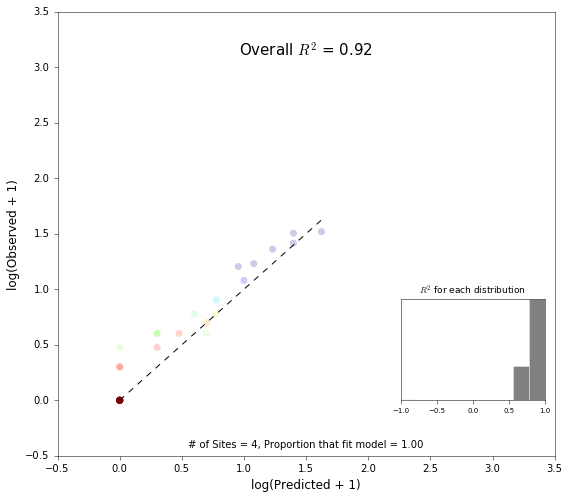

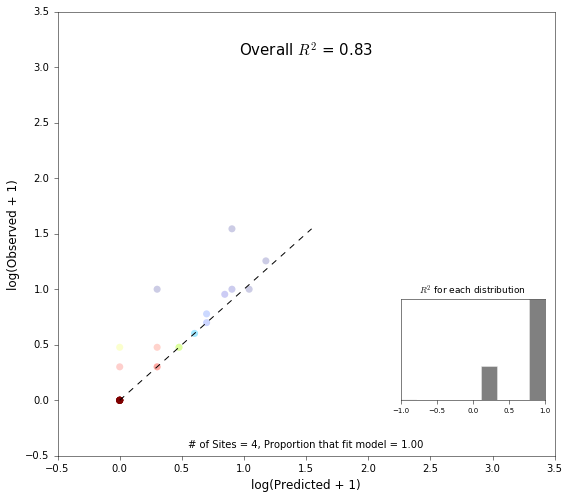

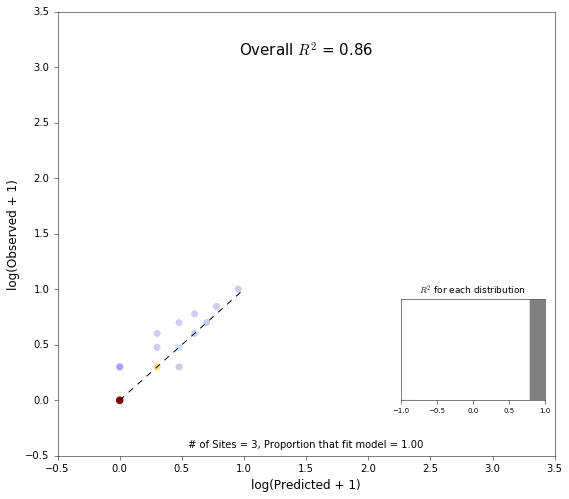

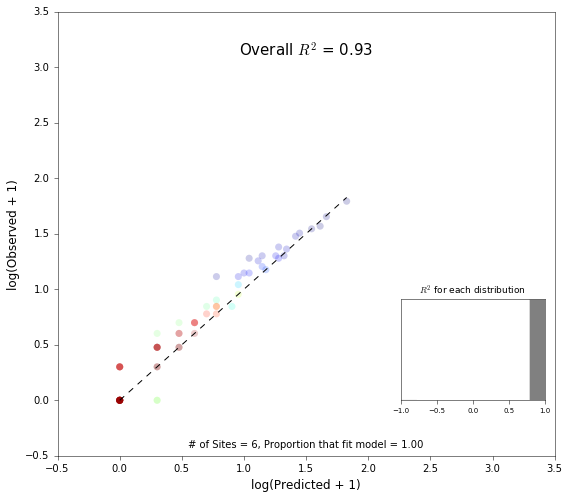

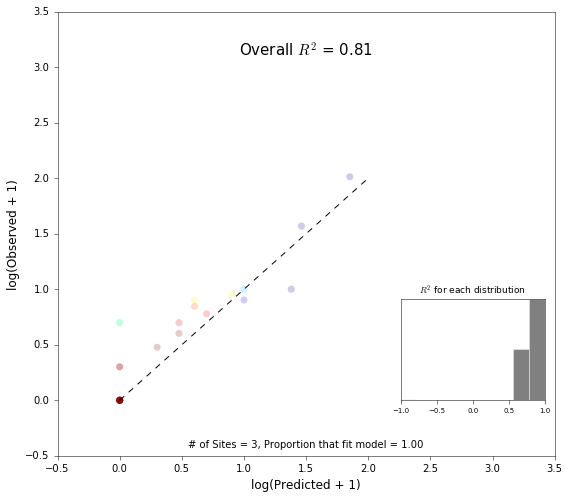

In [20]:
reload(agg)
hosts = ["BUBO", "PSRE", "RACA", "TATO", "TAGR"]
parasites = ['RION', 'ECSP', 'ALAR', "MANO", "GLOB"]
models = ['finite_nbd', 'nbd']

for model in models:
    for host in hosts:
        for parasite in parasites:
        
            foldernm = "../results/plots/continuous_heterogeneity_plots/"
            savenm = foldernm + "continuous_heterogeneity_{0}_{1}_{2}.pdf".format(model, host, parasite)
            
            try:
                rsqs, adp = zip(*agg.extract_obs_pred_stats(td_bu_cont_stats, model, 
                                        host, parasite, ["r_sq_one_to_one", "AD_p_val"]))
                adp = np.array(adp)
                prop_reject = np.sum(adp < 0.1) / np.float(len(adp))
                obs, pred = agg.extract_obs_pred_vectors(td_bu_cont_vectors, model, host, parasite)
                agg.plot_vectors(np.concatenate(obs), np.concatenate(pred), rsqs=rsqs, 
                                 savename=savenm, proportion=(len(rsqs), 1 - prop_reject))
            except:
                pass


## Feasible set explanation plot

A figure to explain what the feasible set calculation is doing.  Put it in the supplementary material

In [21]:
def mode(vect):
    # Function for the mode
    counts = pd.Series(vect).value_counts()
    mode_val = counts[counts == counts.iloc[0]].index.max()
    return mode_val

In [22]:
pred = agg.feasible_mixture([(100, 20)], center="mean", samples=1000)
pred_mean = np.mean(pred[0], axis=0)
pred_mode = np.array(map(mode, [a for a in pred[0].T]))
pred_median = np.median(pred[0], axis=0)

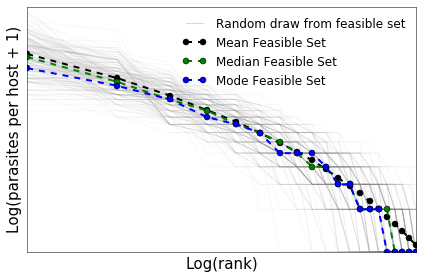

In [23]:
plt.rcParams['text.usetex'] = False
fig, ax = plt.subplots(1, 1)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

vals = np.arange(1, 21)
ax.plot(np.log(vals), np.log(pred[0][:200, :].T + 1), '-', color="grey", alpha=0.05)
ax.plot(np.log(vals), np.log(pred[0].T[:, 0] + 1), '-', color="grey", alpha=0.3, label="Random draw from feasible set")
ax.plot(np.log(vals), np.log(pred_mean + 1), '--o', label="Mean Feasible Set", 
                                                    ms=6, color="black", lw=2)
ax.plot(np.log(vals), np.log(pred_median + 1), '--o', label="Median Feasible Set", 
                                                    ms=6, color="green", lw=2)
ax.plot(np.log(vals), np.log(pred_mode + 1), '--o', label="Mode Feasible Set", 
                                                    ms=6, color="blue", lw=2)
#ax.plot(np.log(vals), np.log(pois + 1), '-o', label="Poisson", ms=4, lw=2, markeredgecolor=colors[1])
ax.set_xlabel("Log(rank)", size=15)
ax.set_ylabel("Log(parasites per host + 1)", size=15)
ax.tick_params(left=None, bottom=None, labelbottom=None, labelleft=None)
ax.legend(frameon=False)
plt.tight_layout()

fig.savefig("../results/feasible_set_explanation.pdf", dpi=300)

## Example RAD figure

Figure to described what a RAD is and what it is doing

In [24]:
para_data = pd.read_csv("../data/archival/dummy_data.csv")
barn = para_data[(para_data.sitecode == "Barn") & (para_data.year == 2013)]

# Get the various predictions
emp = np.sort(barn.RION)
H = len(barn.RION)
P = np.sum(barn.RION)
maxent = agg.nbd_mixture([(P, H)], finite=True)
feas = agg.feasible_mixture([(P, H)], center="median")[1]
binom = agg.poisson_mixture([(P, H)], finite=True)

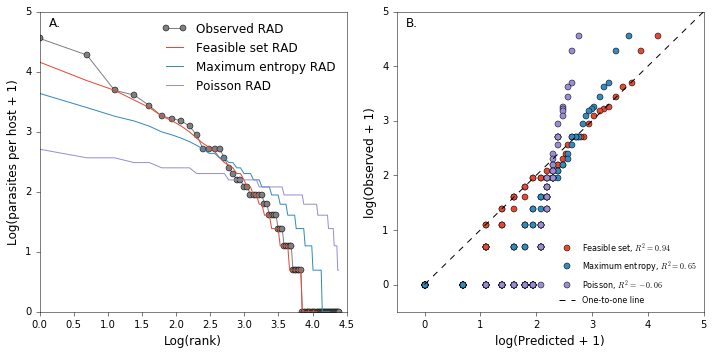

In [25]:
# Make an example plot
import macroeco.compare as comp
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()
for ax in axes:
    ax.tick_params(right=None, top=None)

# Make the RAD plot
ranks = np.arange(1, H + 1)
axes[0].plot(np.log(ranks), np.log(np.sort(emp)[::-1] + 1), '-o', label="Observed RAD", color="grey")
axes[0].plot(np.log(ranks), np.log(feas), '-', label='Feasible set RAD')
axes[0].plot(np.log(ranks), np.log(maxent), '-', label="Maximum entropy RAD")
axes[0].plot(np.log(ranks), np.log(binom), '-', label="Poisson RAD")
axes[0].set_xlabel("Log(rank)")
axes[0].set_ylabel("Log(parasites per host + 1)")
axes[0].legend(frameon=False)
axes[0].text(0.05, 0.95, "A.", size=12, ha="center", transform=axes[0].transAxes)

# Make the one-to-one plot
alpha=1

r2_feas = comp.r_squared(emp[::-1] + 1, feas + 1, one_to_one=True, log_trans=True)
r2_maxent = comp.r_squared(emp[::-1] + 1, maxent + 1, one_to_one=True, log_trans=True)
r2_binom = comp.r_squared(emp[::-1] + 1, binom + 1, one_to_one=True, log_trans=True)

axes[1].plot(np.log(feas + 1), np.log(emp[::-1] + 1), 'o', alpha=alpha, label="Feasible set, $R^2 = {0:.2f}$".format(r2_feas))
axes[1].plot(np.log(maxent + 1), np.log(emp[::-1] + 1), 'o', alpha=alpha, label="Maximum entropy, $R^2 = {0:.2f}$".format(r2_maxent))
axes[1].plot(np.log(binom + 1), np.log(emp[::-1] + 1), 'o', alpha=alpha, label="Poisson, $R^2 = {0:.2f}$".format(r2_binom))

axes[1].plot(np.arange(0, 6), np.arange(0, 6), '--', color="black", label="One-to-one line")
axes[1].set_ylim(-0.5, 5)
axes[1].set_xlim(-0.5, 5)
axes[1].set_xlabel("log(Predicted + 1)")
axes[1].set_ylabel("log(Observed + 1)")
axes[1].legend(loc="lower right", numpoints=1, prop={'size':8}, frameon=False)
axes[1].text(0.05, 0.95, "B.", size=12, ha="center", transform=axes[1].transAxes)

plt.tight_layout()
fig.savefig("../results/example_rad_figure.pdf")

## $R^2$ plots over 5 groups

This plot gives a sense of how $R^2$ changes as we add groups of heterogeneity

In [26]:
# Load in the discrete hetero sites
discrete_hetero_vects = pd.read_pickle("../results/pickled_results/discrete_known_heterogeneity_all_years_vectors_all_para.pkl")
discrete_hetero_stats = pd.read_pickle("../results/pickled_results/discrete_known_heterogeneity_all_years_stats_all_para.pkl")

discrete_hetero_vects_no_svl = pd.read_pickle("../results/pickled_results/discrete_known_heterogeneity_all_years_vectors_only_para.pkl")
discrete_hetero_stats_no_svl = pd.read_pickle("../results/pickled_results/discrete_known_heterogeneity_all_years_stats_only_para.pkl")

discrete_hetero_vects_only_svl = pd.read_pickle("../results/pickled_results/discrete_known_heterogeneity_all_years_vectors_only_svl.pkl")
discrete_hetero_stats_only_svl = pd.read_pickle("../results/pickled_results/discrete_known_heterogeneity_all_years_stats_only_svl.pkl")


over_agg_sites_fs = pd.read_pickle("../results/pickled_results/overaggregated_sites.pkl")[0]

In [27]:
# Get the r^2 values for each model over different groupings
stat = 'r_sq_one_to_one'
models = ["feasible", "trun_geometric", "binomial"]
all_r2s = []
all_r2s_no_svl = []
all_r2s_only_svl = []

for model in models:
    r2_groups = []
    r2_groups_no_svl = []
    r2_groups_only_svl = []
    groups = np.arange(1, 6)

    for g in groups:
        stat_dict = agg.extract_vectors_given_tuple(discrete_hetero_stats, over_agg_sites_fs, model + "_{0}".format(g))
        stat_dict_no_svl = agg.extract_vectors_given_tuple(discrete_hetero_stats_no_svl, over_agg_sites_fs, model + "_{0}".format(g))
        stat_dict_only_svl = agg.extract_vectors_given_tuple(discrete_hetero_stats_only_svl, over_agg_sites_fs, model + "_{0}".format(g))
        r2_groups.append([x.ix[stat] for x in stat_dict])
        r2_groups_no_svl.append([x.ix[stat] for x in stat_dict_no_svl])
        r2_groups_only_svl.append([x.ix[stat] for x in stat_dict_only_svl])
        
    all_r2s.append(r2_groups)
    all_r2s_no_svl.append(r2_groups_no_svl)
    all_r2s_only_svl.append(r2_groups_only_svl)

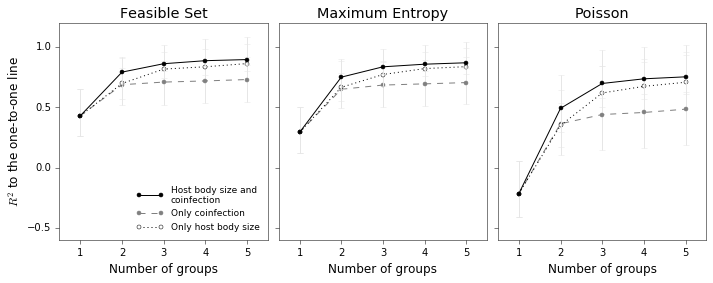

In [28]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 4))
axes = axes.ravel()
mod_names = ["Feasible Set", "Maximum Entropy", "Poisson"]

for i, ax in enumerate(axes):
    
    ax.set_xlim(0.5, 5.5)
    ax.set_xticks(np.arange(1, 6))
    #ax.set_ylim(-2.5, 1.2)
    
    ax.tick_params(right=None, top=None)
    
    trans = pd.DataFrame(all_r2s[i]).T
    trans.columns = np.arange(1, 6)
    stacked = pd.DataFrame(trans.stack()).reset_index()
    stacked.columns = ["dist", "groups", "r2"]
    
    trans_no_svl = pd.DataFrame(all_r2s_no_svl[i]).T
    trans_no_svl.columns = np.arange(1, 6)
    stacked_no_svl = pd.DataFrame(trans_no_svl.stack()).reset_index()
    stacked_no_svl.columns = ["dist", "groups", "r2"]
    
    trans_only_svl = pd.DataFrame(all_r2s_only_svl[i]).T
    trans_only_svl.columns = np.arange(1, 6)
    stacked_only_svl = pd.DataFrame(trans_only_svl.stack()).reset_index()
    stacked_only_svl.columns = ["dist", "groups", "r2"]
    
    
    # Plot each distribution
    #for r2s in zip(*all_r2s[i])[:]:
    #    ax.plot(np.arange(1, 6), r2s, 'o-', color="grey", alpha=0.01)
    
    #for r2s in zip(*all_r2s_no_svl[i])[:]:
    #    ax.plot(np.arange(1, 6), r2s, 'o-', color="green", alpha=0.05, ls="--")
    
    # Plot median
    #ax.plot(np.arange(1, 6), stacked.groupby("groups")['r2'].median(), color="black", lw=3)
    upper = [stats.scoreatpercentile(a, 75) for b, a in stacked.groupby("groups")['r2']]
    lower = [stats.scoreatpercentile(a, 25) for b, a in stacked.groupby("groups")['r2']]
    med = stacked.groupby("groups")['r2'].median()
    
    upper_no_svl = [stats.scoreatpercentile(a, 75) for b, a in stacked_no_svl.groupby("groups")['r2']]
    lower_no_svl = [stats.scoreatpercentile(a, 25) for b, a in stacked_no_svl.groupby("groups")['r2']]
    med_no_svl = stacked_no_svl.groupby("groups")['r2'].median()
    
    upper_only_svl = [stats.scoreatpercentile(a, 75) for b, a in stacked_only_svl.groupby("groups")['r2']]
    lower_only_svl = [stats.scoreatpercentile(a, 25) for b, a in stacked_only_svl.groupby("groups")['r2']]
    med_only_svl = stacked_only_svl.groupby("groups")['r2'].median()
    
    alpha=1
    ecolor="#e6e6e6"#"#f2f2f2"
    colors = ["black", "gray", "green"]
    ms=4
    #ax.plot(np.arange(1, 6), med, '-o', color=colors[0], lw=1, ms=5, alpha=alpha, mec=colors[0], label="Body Size and coinfection")
    ax.errorbar(np.arange(1, 6), med, yerr=[upper - med, med - lower], color=colors[0], 
                        lw=1, elinewidth=1, linestyle="solid", marker="o", ms=ms, ecolor=ecolor, 
                        alpha=alpha, label="Host body size andcoinfection", zorder=2)
    
    #ax.plot(np.arange(1, 6), med_no_svl, '-o', color=colors[1], lw=1, ms=5, linestyle="dashed", alpha=alpha, 
    #                                zorder=-1, mec=colors[1], label="Only coinfection")
    ax.errorbar(np.arange(1, 6), med_no_svl, yerr=[upper_no_svl - med_no_svl, med_no_svl - lower_no_svl], 
                                color=colors[1], lw=1, elinewidth=1, linestyle="dashed", 
                                marker='o', ms=ms, mec=colors[1], ecolor=ecolor, zorder=0, alpha=alpha,
                                label="Just coinfection")
    
    ax.errorbar(np.arange(1, 6), med_only_svl, yerr=[upper_only_svl - med_only_svl, med_only_svl - lower_only_svl], 
                                color="black", lw=1, elinewidth=1, linestyle=":", 
                                marker='o', ms=ms, mec='black', mfc="white", ecolor=ecolor, zorder=1, alpha=alpha,
                                label="Only SVL")
    # Plot 
    #ax.plot(np.arange(1, 6), stacked_no_svl.groupby("groups")['r2'].median(), color="black", lw=1, linestyle="--")
    
    ax.set_title(mod_names[i])
    ax.set_xlabel("Number of groups")
    
    if ax.is_first_col():
        ax.set_ylabel(r"$R^2$ to the one-to-one line")
        ax.legend(["Host body size and\ncoinfection", "Only coinfection", "Only host body size"], loc="lower right", 
                  prop={'size' : 9}, handlelength=3, frameon=False)

plt.tight_layout()
plt.savefig("../results/r2_for_discrete_hetero.pdf")

## Plots of RION distributions after contraining on parasite-induced host mortality


In [29]:
# Load in the simulation data
pihm_vects = pd.read_pickle("../results/pickled_results/parasite_mortality_vects.pkl")

In [30]:
pihm_vects.columns

Index([u'sorter', u'host', u'dist', u'pred', u'observed', u'accept'], dtype='object')

('PSRE', 'feasible')
[ 0.57686063  0.81369213  0.87896245]
('PSRE', 'trun_geometric')
[ 0.53719092  0.804894    0.87923254]
('PSRE', 'binomial')
[ 0.30531722  0.46878507  0.62579167]


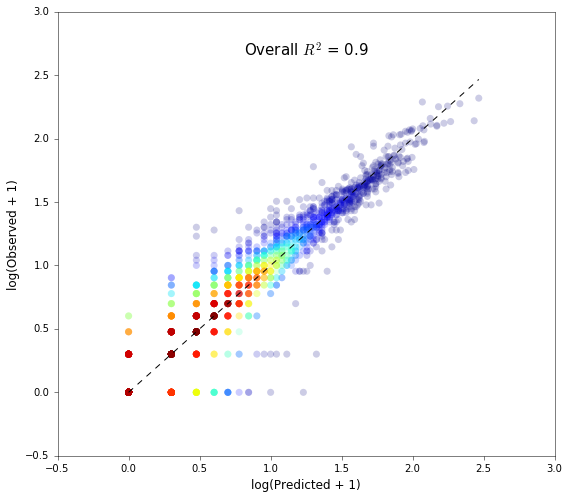

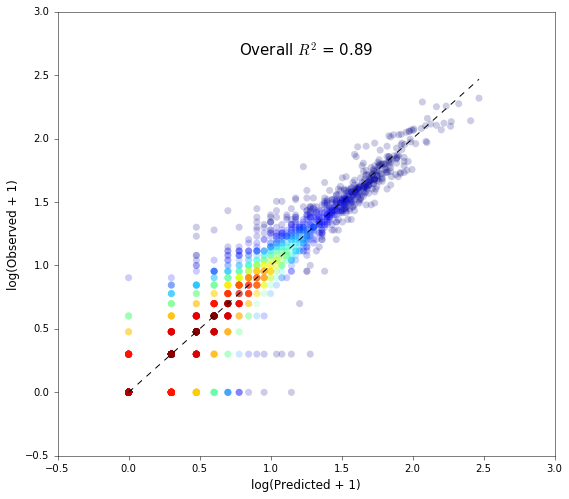

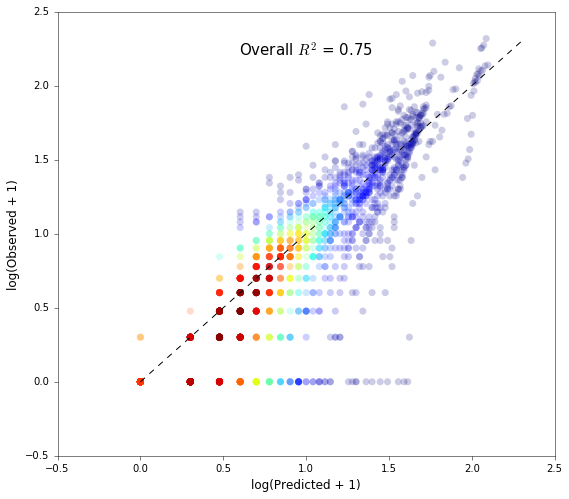

In [31]:
hosts = ['PSRE']#, 'BUBO', 'TATO']
dist_names = ["feasible", "trun_geometric", "binomial"]
lims = [[(-0.5, 3), (-0.5, 3), (-0.5, 2.5)],
        [(-0.5, 2.5), (-0.5, 2.5), (-0.5, 2)],
        [(-0.5, 3.0), (-0.5, 3.0), (-0.5, 2.5)]]

all_rsqs_pihm = []

for k, host in enumerate(hosts):
    
    # Subset on host
    host_dat = pihm_vects[pihm_vects.host == host]
    
    for j, dist in enumerate(dist_names):
        
        # Subset on dist
        dist_dat = host_dat[host_dat.dist == dist]
        
        obs = list(dist_dat.observed)
        pred = list(dist_dat.pred)
        #obs, pred, feas = zip(*pihm_vects[host])

        ad_pvals_pihm = []
        rsqs_pihm = []
        for i in np.arange(len(obs)):

            rsqs_pihm.append(comp.r_squared(obs[i] + 1, pred[i] + 1, one_to_one=True, log_trans=True))
            #ad_pvals_pihm.append(agg.anderson_darling(obs[i], pred[i], nsim=10000))

        print((host, dist))
        print(stats.scoreatpercentile(rsqs_pihm, (25, 50, 75)))
    
#         prop_fit = np.sum(np.array(ad_pvals_pihm) > 0.1) / len(rsqs_pihm)
#         proportion = (len(rsqs_pihm), prop_fit)
        
        # Plot predictions accounting for mortality
        agg.plot_vectors(np.concatenate(obs), np.concatenate(pred), rsqs=None, 
                         savename="../results/parasite_mortality_pihm_{0}_{1}.pdf".format(host, dist), 
                         xlim=lims[k][j], ylim=lims[k][j], proportion=None)
        all_rsqs_pihm.append(rsqs_pihm)

In [32]:
# Extract statistics for models without PIHM
hosts = ['PSRE', 'BUBO', 'TATO']
dist_names = ["feasible", "trun_geometric", "binomial"]

all_rsqs = []
for host in hosts:
    for dist in dist_names:
        rsqs = agg.extract_obs_pred_stats(td_bu_stats, dist, host, "RION", ["r_sq_one_to_one"])
        rsqs = np.array(zip(*rsqs)[0])
        all_rsqs.append(rsqs)
        print((host, dist))
        print(stats.scoreatpercentile(np.array(rsqs), [25, 50, 75]))
        

('PSRE', 'feasible')
[ 0.38553565  0.76787666  0.87619107]
('PSRE', 'trun_geometric')
[ 0.37317475  0.76721615  0.89141206]
('PSRE', 'binomial')
[ 0.31397023  0.48830007  0.64215908]
('BUBO', 'feasible')
[ 0.53815156  0.78908579  0.8573952 ]
('BUBO', 'trun_geometric')
[ 0.53795053  0.77500632  0.87156445]
('BUBO', 'binomial')
[ 0.33226733  0.50109169  0.67488498]
('TATO', 'feasible')
[ 0.55919654  0.81813639  0.89368684]
('TATO', 'trun_geometric')
[ 0.59151235  0.80739275  0.8901468 ]
('TATO', 'binomial')
[ 0.21431924  0.39794668  0.56123424]


In [33]:
# Compute the bootstrap 95% CIs for the R^2s
import pandas as pd
td_bu_vects = pd.read_pickle("../results/pickled_results/no_heterogeneity_all_years_vectors.pkl")
pihm_res = pd.read_pickle("../results/pickled_results/parasite_mortality_vects.pkl")

In [34]:
def rsq_diff(data1, data2):
    # Function to compate differences in over r_squareds
    
    obs1, pred1 = zip(*data1)
    obs2, pred2 = zip(*data2)
    rsq1 = comp.r_squared(np.array(obs1) + 1, np.array(pred1) + 1, one_to_one=True, log_trans=True)
    rsq2 = comp.r_squared(np.array(obs2) + 1, np.array(pred2) + 1, one_to_one=True, log_trans=True)
    return(rsq1 - rsq2)

In [35]:
from sklearn.utils import resample
from scipy.sparse import coo_matrix
import scipy.stats as stats

dists = ["feasible", "trun_geometric", "binomial"]
SAMPS = 999 # Number of boostrapped samples
cis = []

for dist in dists:
    
    # Get null model data
    obs_null, pred_null = agg.extract_obs_pred_vectors(td_bu_vects, dist, 'PSRE', 'RION')
    null_pairs = np.array(zip(np.concatenate(obs_null), np.concatenate(pred_null)))
    
    # Get PIHM constrained data
    psre = pihm_res[(pihm_res.host == "PSRE") & (pihm_res.dist == dist)]
    pihm_pairs = np.array(zip(np.concatenate([np.array(obs) for obs in psre.observed]), 
                          np.concatenate([np.array(pred) for pred in psre.pred])))
    
    # Save the results
    res = []
    res.append(rsq_diff(pihm_pairs, null_pairs)) # Save true result

    for i in range(SAMPS):
    
        tnull, tpihm = resample(coo_matrix(null_pairs), coo_matrix(pihm_pairs))
        res.append(rsq_diff(tpihm.toarray(), tnull.toarray()))
    
    cis.append(stats.scoreatpercentile(res, (2.5, 97.5)))

In [36]:
# Printing the bootstrapped difference between overall R^2 with PIHM and without PIHM for each model
zip(cis, dists)

[(array([ 0.020374  ,  0.03372348]), 'feasible'),
 (array([ 0.01789991,  0.03301935]), 'trun_geometric'),
 (array([-0.00550691, -0.00286794]), 'binomial')]

## Making a figure to help understand the regression tree analysis



In [37]:
dat = pd.read_csv("../data/archival/dummy_data.csv")

In [38]:
# Get a particular site as an example...This is just an illustrative example
sdat = dat[(dat.sitecode == 'VPPND006') & (dat.speciescode == "PSRE")]
#sdat = dat[(dat.sitecode == 'Frog') & (dat.speciescode == "PSRE") & (dat.year == 2009)]
H = len(sdat)
P = np.sum(sdat.ECSP)
print((P, H))

(7043, 60)


In [39]:
# Make trees
ph_vects = []
trees = []

for i in np.arange(2, 6):
    res = agg.cart_analysis(sdat, 'ECSP', ['svl', 'RION', 'GLOB', 'MANO', 'ALAR'], max_leaf_nodes=i, 
                  print_tree=False, filename="../results/dot_files/{0}_group_tree.dot".format(i))
    ph_vects.append(res[0])
    trees.append(res[1])

In [40]:
# Get predictions
hetero1 = agg.nbd_mixture([(np.sum(sdat.ECSP), len(sdat.ECSP))])
hetero2 = agg.nbd_mixture(ph_vects[0])
hetero3 = agg.nbd_mixture(ph_vects[1])
hetero4 = agg.nbd_mixture(ph_vects[2])
hetero5 = agg.nbd_mixture(ph_vects[3])

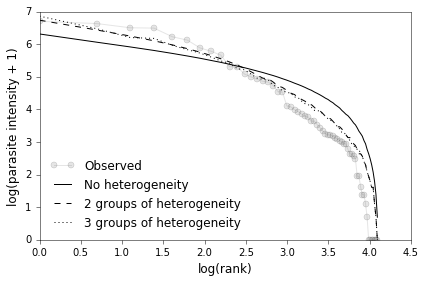

In [42]:
fig, ax = plt.subplots(1, 1)#, figsize=(8, 6))
ranks = np.arange(1, len(sdat) + 1)
ax.plot(np.log(ranks), np.log(np.sort(sdat.ECSP)[::-1] + 1), '-o', 
                                color='grey', alpha=0.2, label="Observed")

ax.plot(np.log(ranks), np.log(hetero1 + 1), '-', label="No heterogeneity", color="black")
ax.plot(np.log(ranks), np.log(hetero2 + 1), '--', label="2 groups of heterogeneity", color="black")
ax.plot(np.log(ranks), np.log(hetero3 + 1), ':', label="3 groups of heterogeneity", color="black")
#ax.plot(np.log(ranks), np.log(hetero4), '-.', label="4 groups of heterogeneity", color="black")
#ax.plot(np.log(ranks), np.log(hetero5), '-', label="5 groups of heterogeneity")

ax.legend(loc="lower left", frameon=False)
ax.tick_params(right=None, top=None)
ax.set_xlabel("log(rank)")
ax.set_ylabel("log(parasite intensity + 1)")
plt.tight_layout()
fig.savefig("../results/example_hetero.pdf")